In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src import evaluation

In [3]:
img_path = "data/images/"
seed = 42
target_size = 224

In [4]:
B = 2
C = 20
S = 7

In [5]:
train_json_path = "data/pascal_train2012.json"
val_json_path = "data/pascal_val2012.json"

In [6]:
id_cat, train_list = dt.load_pascal(train_json_path)
_, val_list = dt.load_pascal(val_json_path)

In [7]:
train_list = dt.rescale_bounding_boxes(train_list, target_size)
val_list = dt.rescale_bounding_boxes(val_list, target_size)

In [8]:
example = train_list[0]
example

['2008_000008.jpg',
 ['horse', 'person'],
 [[23, 44, 188, 169], [70, 22, 59, 63]],
 [12, 14]]

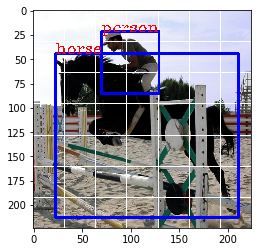

In [9]:
img_str = img_path + example[0]
img = display.read_img(img_str, target_size)

img = display.draw_grid(img, int(np.ceil(target_size / S)))
img = display.draw_boxes(img, example[2])
img = display.draw_text(img, example[1], example[2])
plt.imshow(img)
plt.show()

In [10]:
def create_yolo_target(data_list, S, B, C, target_size):    
    grid_size = target_size / S

    y_list = []

    for data in data_list: 
        # For one grid element: [pc, c1, ..., cN, b1x, b1y, w1, h1, b2x, b2y, w2, h2]
        y = np.zeros((1, S, S, 5*B + C))

        boxes = data[2]
        classes = data[3]

        for i in range(len(boxes)):
            box = boxes[i]

            center_width = box[0] + box[2]/2
            center_height = box[1] + box[3]/2

            width_index = int(np.floor((center_width / target_size) * S))
            height_index = int(np.floor((center_height / target_size) * S))

            class_index = classes[i]

            # Normalize width and height by the enitre image size
            w = box[2] / target_size
            h = box[3] / target_size

            # Normalize bx and by according to the current grid position
            bx = (center_width - ((width_index / S) * target_size)) / grid_size
            by = (center_height - ((height_index / S) * target_size)) / grid_size

            y[:, width_index, height_index, class_index] = 1.0

            # Hardcoded for B=2
            if y[:, width_index, height_index, 20] == 0.0:
                y[:, width_index, height_index, 20] = 1.0
                y[:, width_index, height_index, 21] = bx
                y[:, width_index, height_index, 22] = by
                y[:, width_index, height_index, 23] = w
                y[:, width_index, height_index, 24] = h
            else:
                y[:, width_index, height_index, 25] = 1.0
                y[:, width_index, height_index, 26] = bx
                y[:, width_index, height_index, 27] = by
                y[:, width_index, height_index, 28] = w
                y[:, width_index, height_index, 29] = h

        y_list.append(y)
    y = np.concatenate(y_list, axis=0)
    
    return y

In [11]:
y_train = create_yolo_target(train_list, S, B, C, target_size)
y_val = create_yolo_target(val_list, S, B, C, target_size)

In [12]:
class PascalData(Dataset):
    def __init__(self, data_list, y, lambda_indicator, target_size=target_size, path=img_path):
        self.target_size = target_size
        self.path = path
        
        self.lambda_indicator = torch.from_numpy(lambda_indicator).float()
        
        self.y = torch.from_numpy(y).float()
        self.file_list = [i[0] for i in data_list]      
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]
        
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().to(device)
        
        temp_y = self.y[idx,:].to(device)
        temp_lambda = self.lambda_indicator[idx, :, :, :].to(device)
        
        return (img, temp_y, temp_lambda)

In [13]:
def create_lambda_indicator(y, lambda_coord=5.0, lambda_noobj=0.5):
    lambda_indicator = (y > 0.0).astype(float)

    lambda_indicator[:, :, :, 0:20][(lambda_indicator[:, :, :, 20] != 0.0) | 
                                    (lambda_indicator[:, :, :, 25] != 0.0)] = 1.0

    lambda_indicator[:, :, :, 20][lambda_indicator[:, :, :, 20] == 0.0] = lambda_noobj
    lambda_indicator[:, :, :, 21] = lambda_indicator[:, :, :, 21]*lambda_coord
    lambda_indicator[:, :, :, 22] = lambda_indicator[:, :, :, 22]*lambda_coord
    lambda_indicator[:, :, :, 23] = lambda_indicator[:, :, :, 23]*lambda_coord
    lambda_indicator[:, :, :, 24] = lambda_indicator[:, :, :, 24]*lambda_coord

    lambda_indicator[:, :, :, 25][lambda_indicator[:, :, :, 25] == 0.0] = lambda_noobj
    lambda_indicator[:, :, :, 26] = lambda_indicator[:, :, :, 26]*lambda_coord
    lambda_indicator[:, :, :, 27] = lambda_indicator[:, :, :, 27]*lambda_coord
    lambda_indicator[:, :, :, 28] = lambda_indicator[:, :, :, 28]*lambda_coord
    lambda_indicator[:, :, :, 29] = lambda_indicator[:, :, :, 29]*lambda_coord
    
    return lambda_indicator

In [14]:
def loss(y, y_hat, indicator):
    y[:,:,:,23] = torch.sqrt(y[:,:,:,23])
    y[:,:,:,24] = torch.sqrt(y[:,:,:,24])
    y[:,:,:,28] = torch.sqrt(y[:,:,:,28])
    y[:,:,:,29] = torch.sqrt(y[:,:,:,29])
    
    y_hat[:,:,:,23] = torch.sqrt(y_hat[:,:,:,23])
    y_hat[:,:,:,24] = torch.sqrt(y_hat[:,:,:,24])
    y_hat[:,:,:,28] = torch.sqrt(y_hat[:,:,:,28])
    y_hat[:,:,:,29] = torch.sqrt(y_hat[:,:,:,29])
    
    return torch.sum(indicator * ((y - y_hat)*(y - y_hat)))

In [15]:
class Model(nn.Module):
    def __init__(self, n_hidden=4096):
        super().__init__()
        
        # Removing fc layer
        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)
        
        self.fc = nn.Linear(512*7*7, n_hidden)
        self.fc_out = nn.Linear(n_hidden, S*S*(5*B + C))
        
        self.drop = nn.Dropout(0.5)        
                                      
    def forward(self, x):
        x = self.pretrained_model(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = F.relu(x)
        # x = self.drop(x)
        
        x = self.fc_out(x)
        x = x.view(x.size(0), S, S, (5*B + C))
        x = F.relu(x)
        return x
    
    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [16]:
device = "cuda"
model = Model()
model = model.to(device)
model.change_freezing(False)

In [17]:
train_lambda_indicator = create_lambda_indicator(y_train)
val_lambda_indicator = create_lambda_indicator(y_val)

In [18]:
batch_size = 64
n_epochs = 40
lr = 2e-5
wd = 0.0005

In [19]:
train_dataset = PascalData(train_list, y_train, train_lambda_indicator)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset = PascalData(val_list, y_val, val_lambda_indicator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [20]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [21]:
validation_evaluation = False

In [22]:
torch.manual_seed(seed)

for epoch in range(1, n_epochs+1):
    print(f"----- epoch {epoch} -----")
    
    model.train()
    train_loss = 0
    
    for _, (x_i, y_i, indicator_i) in enumerate(train_loader):
        model.zero_grad()
        y_hat = model(x_i)
        batch_loss = loss(y_i, y_hat, indicator_i)

        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss / batch_size
    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    
    print("Train loss: {:.4f}".format(train_loss))
    
    if validation_evaluation:
        model.eval()
        val_loss = 0

        for _, (x_i, y_i, indicator_i) in enumerate(val_loader):
            y_hat = model(x_i)
            batch_loss = loss(y_i, y_hat, indicator_i)
            val_loss += batch_loss / batch_size
        val_loss = (val_loss/len(val_loader)).detach().cpu().numpy()
    
        print("Val loss: {:.4f}".format(val_loss))

----- epoch 1 -----
Train loss: 9.9987
----- epoch 2 -----
Train loss: 6.0769
----- epoch 3 -----
Train loss: 4.5595
----- epoch 4 -----
Train loss: 3.8906
----- epoch 5 -----
Train loss: 3.5493
----- epoch 6 -----
Train loss: 3.2777
----- epoch 7 -----
Train loss: 3.0465
----- epoch 8 -----
Train loss: 2.9384
----- epoch 9 -----
Train loss: 2.7867
----- epoch 10 -----
Train loss: 2.6912
----- epoch 11 -----
Train loss: 2.6283
----- epoch 12 -----
Train loss: 2.5194
----- epoch 13 -----
Train loss: 2.4959
----- epoch 14 -----
Train loss: 2.4236
----- epoch 15 -----
Train loss: 2.3223
----- epoch 16 -----
Train loss: 2.2140
----- epoch 17 -----
Train loss: 2.1427
----- epoch 18 -----
Train loss: 2.1033
----- epoch 19 -----
Train loss: 2.0383
----- epoch 20 -----
Train loss: 2.0012
----- epoch 21 -----
Train loss: 1.9875
----- epoch 22 -----
Train loss: 1.9976
----- epoch 23 -----
Train loss: 1.9713
----- epoch 24 -----
Train loss: 1.9188
----- epoch 25 -----
Train loss: 1.8383
----- epo

In [23]:
index = 5
dataset = train_dataset
(x_i, _, _) = dataset[index]

model.eval()
y_hat = model(x_i.reshape(1, 3, target_size, target_size))
y_hat = y_hat.detach().cpu().numpy()

In [24]:
grid_size = target_size / S
pc_threshold = 0.25

output_bb = []
class_id_list = []

for i in range(S):
    for j in range(S):
        found_object = False
        
        for b in range(B):
            pc = y_hat[:, i, j, 20 + 5*b]

            if pc < pc_threshold:
                continue
            else:
                found_object = True
        
            box_width = y_hat[:, i, j, 23 + 5*b]*target_size
            box_height = y_hat[:, i, j, 24 + 5*b]*target_size
            
            bx = (i + y_hat[:, i, j, 21 + 5*b])*grid_size - box_width/2
            by = (j + y_hat[:, i, j, 22 + 5*b])*grid_size - box_height/2   
            
            output_bb.append([pc[0], bx[0], by[0], box_width[0], box_height[0]])
        
        if found_object:
            class_id_list.append(np.argmax(y_hat[:, i, j, 0:20][0,:]))

class_name_list = [id_cat[c] for c in class_id_list]

In [25]:
for i in range(len(output_bb)):
    output_bb[i].insert(1, (class_name_list[i]))
    output_bb[i].insert(1, class_id_list[i])
    
output_bb = sorted(output_bb, key = lambda x: x[0], reverse=True)
output_bb

[[1.0080112, 0, 'aeroplane', 42.289978, 43.579338, 171.42004, 152.03987]]

In [26]:
filtered_bb = evaluation.non_max_suppression(output_bb)
filtered_bb

[[1.0080112, 0, 'aeroplane', 42.289978, 43.579338, 171.42004, 152.03987]]

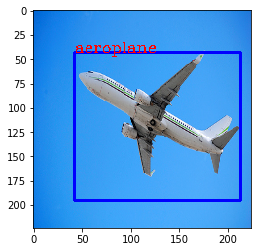

In [27]:
img_file = dataset.file_list[index]
img_str = img_path + img_file

img = display.read_img(img_str, target_size)
img = display.draw_boxes(img, [bb[3:] for bb in filtered_bb])
img = display.draw_text(img, [bb[2] for bb in filtered_bb], [bb[3:] for bb in filtered_bb])

plt.imshow(img)
plt.show()